<a href="https://colab.research.google.com/github/rishantmallick/genai-resume-screening/blob/main/genai_resume_screening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openai  python-dotenv numpy
!pip install langchain_google_genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.5 MB/s eta 0:00:00
  Attempting uninstall: google-ai-generativelanguage
    Found existing installation: google-ai-generativelanguage 0.6.15
    Uninstalling google-ai-generativelanguage-0.6.15:
      Successfully uninstalled google-ai-generativelanguage-0.6.15
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive (optional for saving token.json permanently)

Mounted at /content/drive


In [ ]:
# Install required packages
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 60.1 MB/s eta 0:00:00
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 2.172.0
    Uninstalling google-api-python-client-2.172.0:
      Successfully uninstalled google-api-python-client-2.172.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


In [ ]:
from google_auth_oauthlib.flow import InstalledAppFlow
from google.colab import auth, files
import os

# Define the required Gmail API scopes
SCOPES = ['https://www.googleapis.com/auth/gmail.readonly']

def generate_token():
    # Upload your credentials.json
    print("Please upload your credentials.json file:")
    files.upload()  # This will prompt you to upload the file

    # Create the flow using the credentials.json
    flow = InstalledAppFlow.from_client_secrets_file(
        'credentials.json',
        SCOPES,
        redirect_uri='urn:ietf:wg:oauth:2.0:oob'
    )

    # Get the authorization URL
    auth_url, _ = flow.authorization_url(prompt='consent')

    print('\nPlease visit this URL to authorize the application:')
    print(auth_url)

    # The user will paste the authorization code here
    code = input('\nEnter the authorization code: ')

    # Exchange the code for tokens
    flow.fetch_token(code=code)
    creds = flow.credentials

    # Save the credentials
    with open('token.json', 'w') as token:
        token.write(creds.to_json())

    print("\ntoken.json generated successfully!")
    return creds

# Run the function
generate_token()

Please upload your credentials.json file:


Saving credentials.json to credentials.json

Please visit this URL to authorize the application:
https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=476294476347-vfajlm4ho0kes9an08app57u6qisnos0.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgmail.readonly&state=sSd8GJMSGh372pJKxlaEfxYE3SUedf&prompt=consent&access_type=offline

Enter the authorization code: 4/1AUJR-x69F2XPsi5iEsAq-_d8XCyFCISX0lNScpPHrX71Zj51eS5_q1rnCMM

token.json generated successfully!


In [ ]:
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib python-dotenv

In [ ]:
import os
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from dotenv import load_dotenv

load_dotenv()

# Scopes for Gmail API
SCOPES = ['https://www.googleapis.com/auth/gmail.readonly']

def authenticate_gmail():
    creds = None
    if os.path.exists('token.json'):
        creds = Credentials.from_authorized_user_file('token.json', SCOPES)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
            creds = flow.run_local_server(port=0)
        with open('token.json', 'w') as token:
            token.write(creds.to_json())
    return creds

In [ ]:
from googleapiclient.discovery import build
import base64
import re
from google_auth_oauthlib.flow import InstalledAppFlow

def search_emails(service, query):
    results = service.users().messages().list(userId='me', q=query).execute()
    return results.get('messages', [])

def get_message(service, msg_id):
    return service.users().messages().get(userId='me', id=msg_id, format='full').execute()

def extract_attachments(service, msg_id):
    message = service.users().messages().get(userId='me', id=msg_id).execute()
    parts = message['payload'].get('parts', [])
    attachments = []
    for part in parts:
        if part['filename'] and part['filename'].endswith(('.pdf', '.docx', '.txt')):
            attachment_id = part['body']['attachmentId']
            attachment = service.users().messages().attachments().get(
                userId='me', messageId=msg_id, id=attachment_id).execute()
            file_data = base64.urlsafe_b64decode(attachment['data'].encode('UTF-8'))
            attachments.append({
                'filename': part['filename'],
                'data': file_data
            })
    return attachments

def main():
    creds = authenticate_gmail()
    service = build('gmail', 'v1', credentials=creds)

    # Search for emails with resumes (customize query)
    emails = search_emails(service, "has:attachment (resume OR CV)")
    for email in emails:
        msg = get_message(service, email['id'])
        subject = next(h['value'] for h in msg['payload']['headers'] if h['name'] == 'Subject')
        print(f"Processing email: {subject}")

        # Extract attachments
        attachments = extract_attachments(service, email['id'])
        for attachment in attachments:
            with open(attachment['filename'], 'wb') as f:
                f.write(attachment['data'])
            print(f"Saved: {attachment['filename']}")

if __name__ == '__main__':
    main()

Processing email: Application for Graphics Designer at Rishant&Co
Saved: Modern Minimalist CV Resume.pdf
Processing email: Application for Graphics Designer at Rishant&Co
Saved: Simple Professional CV Resume.pdf
Processing email: Resume for Job Application
Saved: download.pdf
Processing email: Application for Marketing Manager at Rishant&Co
Saved: Blue Simple Professional CV Resume.pdf


In [ ]:
def search_emails(service, query, max_results=20):
    results = service.users().messages().list(
        userId='me',
        q=query,
        maxResults=max_results
    ).execute()
    messages = results.get('messages', [])

    for message in messages:
        msg = service.users().messages().get(
            userId='me',
            id=message['id'],
            format='metadata',
            metadataHeaders=['From', 'Subject', 'Date']
        ).execute()

        headers = {h['name']: h['value'] for h in msg['payload']['headers']}
        print(f"\nDate: {headers.get('Date')}")
        print(f"From: {headers.get('From')}")
        print(f"Subject: {headers.get('Subject')}")
        print(f"ID: {message['id']}")



In [ ]:
!pip install langchain langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 13.9 MB/s eta 0:00:00


In [ ]:
from typing import TypedDict, List, Optional
from typing import Annotated
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
class paper(TypedDict):
  messages:Annotated[list, add_messages]
  question:Annotated[list, add_messages]
  answer:Annotated[list, add_messages]
  evalfinish:bool
  conversational_history:list[str]
  finished:bool
  status:str

In [ ]:
import requests
from langchain_google_genai import ChatGoogleGenerativeAI
import os
from dotenv import load_dotenv
load_dotenv()

False

In [ ]:
!pip install langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.9/438.9 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.65
    Uninstalling langchain-core-0.3.65:
      Successfully uninstalled langchain-core-0.3.65


In [ ]:
from google.colab import userdata
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY_1')
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [ ]:
from langchain_openai import ChatOpenAI

In [ ]:
def answerer(resume:paper)->paper:
   llm = ChatGoogleGenerativeAI(model = "gemini-1.5-pro",temperature = 0)
   nora = resume["answer"][-1].content

   if (resume["evalfinish"] is False and resume["finished"] is False):
     mess = [{"role":"system","content":f'''ROLE: Answer Evaluation Specialist
TASK: Assess responses against resume claims

RESUME DATA:
{resume["messages"]}

EVALUATION CRITERIA:
1. Consistency (1-5):
   5 = Fully aligns with resume
   1 = Direct contradiction
2. Depth (1-5):
   5 = Quantifiable results + technical details
   1 = Vague/general statements
3. Red Flags:
   - Skill exaggeration
   - Timeline mismatches
   - Responsibility inflation

RULES:
1. Always provide:
   - Consistency score
   - Depth score
   - Specific notes
2. Format:
Evaluation:
- Consistency: [X]/5
- Depth: [Y]/5
- Notes: [Key observations]
- Suggested Follow-up: [Question OR "Proceed"]

EXAMPLE:
Candidate: "I reduced server costs by 40% during AWS migration"
Evaluation:
- Consistency: 5/5 (matches "AWS migration" in resume)
- Depth: 5/5 (quantified impact)
- Notes: Confirms leadership claim
- Suggested Follow-up: "What cost-optimization strategies did you use?"'''},
           {"role":"user","content":nora}]
     ert = llm.invoke(mess)
     resume["conversational_history"].append(ert.content)
   if(resume["evalfinish"] is True and resume["finished"] is not True):
      resume["finished"] = True
   return resume



In [ ]:
!pip install langchain_core

In [ ]:
from langchain_core.messages import HumanMessage, AIMessage
def llm_interviewer(resume:paper)->paper:
  questions = resume.get("question", [])
  if questions:
    question_instruction = f"Check the previous questions asked by checking {questions} to avoid repetition."
  else:
    question_instruction = f"Ask a new question based on {resume['messages']}"
  intro_instruction = (
    "Start with a brief introduction."
    if not resume.get("conversational_history")
    else "Continue naturally and don't reintroduce yourself. Say things like 'Great' or 'Thanks for that' as appropriate."
)
  message = resume["messages"]
  llm = ChatOpenAI(model = "gpt-4o",temperature = 0)

  farod = f'''You are an AI interviewer designed to conduct a professional, multi-turn job interview based on the candidate's resume.
    Your goal is to ask relevant, insightful, and tailored questions about their experience, skills, projects, and career goals.
    you will first critically analyze {resume["messages"]} which is the resume content.
Instructions:
1. Ask open-ended, behavioral, and situational questions based on their resume.
2. Cross-check answers with the {resume["messages"]}. If inconsistent, ask for clarification.
3. Ask  technical/behavioral question also.
4. Progress from general to more in-depth questions.
5. {question_instruction}
6. Adapt follow-up questions based on { resume.get("answer") if resume["answer"] else resume["messages"]}
7. Maintain a professional and engaging tone.
8. {intro_instruction}
Example Questions (Tailored to Resume):
"I see you worked at [Company] as a [Role]. Can you walk me through a key project you contributed to and the impact it had?"
"You mentioned [Skill] in your resume. Could you share an example of how you applied it in a real-world scenario?"
"Your resume indicates you led [Project/Initiative]. What challenges did you face, and how did you overcome them?"
"What motivated you to transition from [Previous Role] to [Current/Desired Role]?"
Follow-Up & Probing:
1. Ask for clarifications, deeper insights, or STAR (Situation-Task-Action-Result) formatted responses when needed.
2. Avoid yes/no questions; encourage detailed answers.

Output Format:
1. Speak naturally, like a human interviewer.
2. Keep responses concise but engaging.
3. Allow the candidate time to respond before continuing. '''


  response = llm.invoke(farod)

  return resume|{"question":[response]}

In [ ]:
from typing import Annotated
from typing import Literal
from langgraph.graph import StateGraph, START,END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage
def human_node(resume:paper)->paper:
  if(resume["evalfinish"]==False):
   last_msg = resume["question"][-1]

   print("Model:", last_msg.content)
   user_input = input("User: ")
    # If it looks like the user is trying to quit, flag the conversation
    # as over.

   if user_input.lower().strip() in {"exit","end interview", "end","end the interview","quit"}:
        resume["evalfinish"] = True

   return  resume|{"answer":[("user", user_input)]}
  else:
    return resume

def maybe_exit_human_node(state: paper) -> Literal["interviewer", "goodbye"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return "goodbye"

    return "interviewer"
def goodbye(resume:paper)->paper:
   last_msg = AIMessage(content="Thank you for the opportunity—I really enjoyed our conversation.")
   print("Model:",last_msg.content)
   return resume
def result(resume:paper)->paper:
  llm = ChatGoogleGenerativeAI(model = "gemini-1.5-pro",temperature = 0)
  prompt = f'''compare {resume["messages"]} and {resume["conversational_history"]} and on the basis of it
                tell whether you selected or not. just display SELECTED or REJECTED'''

  ert = llm.invoke(prompt)
  resume["status"] = ert.content

  return resume

In [ ]:
def extract_resume(file_path):
 api_key = "aff_6e21a150f8c81012b6553e32b5ce17e051618b48"
 url = "https://api.affinda.com/v2/resumes"

 headers = {
    "Authorization": f"Bearer {api_key}",
}
 with open(file_path, "rb") as file:
    files = {"file": (file_path, file, "application/pdf")}
    response = requests.post(url, headers=headers, files=files)

 return response.json()  # Extracted resume in JSON
def properties(data):
  import json

  contact = {
    "phone": data["data"]["phoneNumbers"][0],
    "email": data["data"]["emails"][0],
    "location": data["data"]["location"]["formatted"],
    "links": data["data"]["websites"]
}

  role = data["data"]["profession"]
  name = data["data"]["name"]["raw"]

  internship = {
    "jobTitle": data["data"]["workExperience"][1]["jobTitle"],
    "organization": data["data"]["workExperience"][1]["organization"],
    "dates": data["data"]["workExperience"][1]["dates"]["rawText"],
    "description": [line.strip() for line in data["data"]["workExperience"][1]["jobDescription"].split("\n") if line.strip()]
}

  education = [{
    "degree": data["data"]["education"][0]["accreditation"]["inputStr"],
    "institution": data["data"]["education"][0]["organization"],
    "dates": data["data"]["education"][0]["dates"]["rawText"],
    "details": [line.strip() for line in data["data"]["sections"][1]["text"].split("\n") if "•" in line]
}]

  experience = {
    "jobTitle": data["data"]["workExperience"][0]["jobTitle"],
    "organization": data["data"]["workExperience"][0]["organization"],
    "dates": data["data"]["workExperience"][0]["dates"]["rawText"],
    "description": [line.strip() for line in data["data"]["workExperience"][0]["jobDescription"].split("\n") if line.strip()]
}

  skills = [skill["name"] for skill in data["data"]["skills"]]

# Output
  info = json.dumps({
    "contact": contact,
    "role": role,
    "name": name,
    "internship": internship,
    "education": education,
    "experience": experience,
    "skills": skills
}, indent=2)
  return info

In [ ]:

# Main Execution
if __name__ == '__main__':
    SCOPES = ['https://www.googleapis.com/auth/gmail.readonly']
    creds = authenticate_gmail()
    service = build('gmail', 'v1', credentials=creds)

    # Customize your search query here
    search_query = input("Enter your Gmail search query (e.g., 'from:example@domain.com'): ")
    search_emails(service, search_query)


Enter your Gmail search query (e.g., 'from:example@domain.com'): resume

Date: Sat, 21 Jun 2025 23:34:57 +0530
From: Rishant Mallick <rishantmallick06@gmail.com>
Subject: Application for Graphics Designer at Rishant&Co
ID: 19793aa4665fbc1c

Date: Sat, 21 Jun 2025 22:23:23 +0530
From: Rishant Mallick <rishantmallick06@gmail.com>
Subject: Application for Graphics Designer at Rishant&Co
ID: 1979368bfcefd33f

Date: Sat, 21 Jun 2025 16:43:01 +0530
From: Rishant Mallick <rishantmallick06@gmail.com>
Subject: Resume for Job Application
ID: 197923121da4240b

Date: Sat, 21 Jun 2025 16:10:22 +0530
From: Rishant Mallick <rishantmallick06@gmail.com>
Subject: Application for Marketing Manager at Rishant&Co
ID: 19792133ed9ce602

Date: Sat, 14 Jun 2025 12:47:00 -0700
From: Rod from Buildbook <hello@buildbook.us>
Subject: Buildbook San Francisco - Summer Internship
ID: 19770014aee9953b

Date: Thu, 12 Jun 2025 13:10:33 +0000
From: Coursera <Coursera@m.learn.coursera.org>
Subject: Launch your cybersecuri

In [ ]:
ravit = get_message(service,"197923121da4240b")
print(ravit)
ravi = extract_attachments(service,"197923121da4240b")
print(ravi)

{'id': '197923121da4240b', 'threadId': '1979225dd2af2b67', 'labelIds': ['IMPORTANT', 'SENT', 'INBOX'], 'snippet': 'Subject: Application for Digital Content Creator at Rishant&amp;Co Dear Rishant Mallick, I hope you&#39;re doing well. I am excited to apply for the [Job Position] role at Rishant&amp;Co . As a', 'payload': {'partId': '', 'mimeType': 'multipart/mixed', 'filename': '', 'headers': [{'name': 'MIME-Version', 'value': '1.0'}, {'name': 'Date', 'value': 'Sat, 21 Jun 2025 16:43:01 +0530'}, {'name': 'Message-ID', 'value': '<CABFPdATUu4WOv0uKNhuXcFrWkUUC30inh4A1c+bmJ5na4qBm6g@mail.gmail.com>'}, {'name': 'Subject', 'value': 'Resume for Job Application'}, {'name': 'From', 'value': 'Rishant Mallick <rishantmallick06@gmail.com>'}, {'name': 'To', 'value': 'Rishant Mallick <rishantmallick06@gmail.com>'}, {'name': 'Content-Type', 'value': 'multipart/mixed; boundary="000000000000e743060638130f2f"'}], 'body': {'size': 0}, 'parts': [{'partId': '0', 'mimeType': 'multipart/alternative', 'filena

In [ ]:
eitan = extract_resume(ravi[0]['filename'])
print(eitan)
prince = properties(eitan)
print(prince)

{'data': {'certifications': [], 'dateOfBirth': None, 'education': [{'id': 94056340, 'organization': 'UNIVERSITY OF RICHMOND', 'accreditation': {'education': 'Bachelor of Arts', 'educationLevel': 'bachelors', 'inputStr': 'Bachelor of Arts in Film and Media Studies', 'matchStr': ''}, 'grade': {'raw': 'GPA: 3.70', 'value': '3.70', 'metric': 'GPA'}, 'location': None, 'dates': {'startDate': '2018-01-01', 'completionDate': '2022-01-01', 'isCurrent': False, 'rawText': '2018 - 2022'}}, {'id': 94056341, 'organization': 'UNIVERSITY', 'accreditation': {'educationLevel': None, 'inputStr': '', 'matchStr': ''}, 'grade': None, 'location': None, 'dates': {'startDate': None, 'completionDate': '2022-01-01', 'isCurrent': False, 'rawText': '(2022)'}}], 'emails': ['wade-calhoun@email.com'], 'location': {'formatted': 'Richmond, VA, USA', 'streetNumber': None, 'street': None, 'apartmentNumber': None, 'city': 'Richmond', 'postalCode': None, 'state': 'Virginia', 'stateCode': 'VA', 'country': 'United States', '

In [ ]:
graph_builder = StateGraph(paper)
graph_builder.add_node("human",human_node)
graph_builder.add_node("interviewer",llm_interviewer)
graph_builder.add_node("answerer",answerer)
graph_builder.add_node("goodbye",goodbye)
graph_builder.add_node("result",result)
graph_builder.add_conditional_edges("answerer", maybe_exit_human_node,{
        "interviewer": "interviewer",
        "goodbye": "goodbye"
    })
graph_builder.add_edge( "interviewer","human")
graph_builder.add_edge("human", "answerer")

graph_builder.set_entry_point("interviewer")

graph_builder.add_edge("goodbye","result")
graph_builder.add_edge("result",END)
graph = graph_builder.compile()

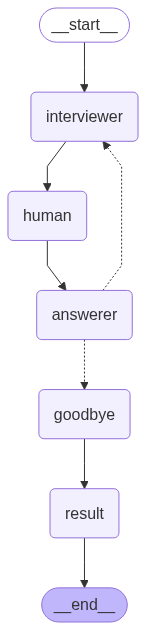

In [ ]:
from IPython.display import Image, display
Image(graph.get_graph().draw_mermaid_png())

In [ ]:
erp = graph.invoke({"messages":[prince],"question":[],"answer":[],"conversational_history":[],"evalfinish":False,"finished":False,"status":" "})
print(erp["status"])

Model: Hello Wade, thank you for joining me today. I'm excited to learn more about your experience and skills as a Video Content Creator. Let's start with your current role at VideoFocus Productions. Can you walk me through a key project you've worked on there and the impact it had on the client or the company?
User: Thank you for the opportunity! At VideoFocus Productions, a standout project was a social media campaign I developed for a local healthcare client aiming to raise awareness about mental wellness. Drawing on my expertise in full-cycle production (as mentioned in my 'Professional Summary'), I led the project from concept to delivery—writing scripts tailored to their brand voice, filming patient testimonials with a compassionate tone, and editing the final cuts using Adobe Premiere Pro (listed under 'Skills').  To maximize impact, I applied SEO strategies and Google Analytics (also in 'Skills') to optimize video titles and descriptions, which helped the campaign reach 50,000+

In [ ]:
ravit = get_message(service,"19793aa4665fbc1c")
ravi = extract_attachments(service,"19793aa4665fbc1c")
eitan = extract_resume(ravi[0]['filename'])
prince = properties(eitan)
print(prince)

{
  "contact": {
    "phone": "+123 - 456 - 7890",
    "email": "hello@reallygreatsite.com",
    "location": null,
    "links": []
  },
  "role": "Senior Graphic designer",
  "name": "Isabel Schumacher",
  "internship": {
    "jobTitle": "SENIOR GRAPHIC DESIGNER",
    "organization": "Larana",
    "dates": "(2017 - 2019)",
    "description": [
      "create more than 100 graphic designs for big companies complete a lot of complicated work"
    ]
  },
  "education": [
    {
      "degree": "Bachelor of Design",
      "institution": "Wardiere University",
      "dates": "(2014 -2019)",
      "details": []
    }
  ],
  "experience": {
    "jobTitle": "SENIOR GRAPHIC DESIGNER",
    "organization": "FAUGET STUDIO",
    "dates": "(2020 -2023)",
    "description": [
      "create more than 100 graphic designs for big companies complete a lot of complicated work"
    ]
  },
  "skills": [
    "Marketing",
    "Search Engine Optimization",
    "Branding",
    "Web Design",
    "Graphic Design"
 

In [ ]:
erp = graph.invoke({"messages":[prince],"question":[],"answer":[],"conversational_history":[],"evalfinish":False,"finished":False,"status":" "})
print(erp["status"])

Model: Hello Isabel, thank you for joining us today. I'm excited to learn more about your experience and skills as a Senior Graphic Designer. Let's start with your role at Fauget Studio. Can you walk me through a key project you contributed to there and the impact it had on the company or the client?
User: Thank you for having me! At Fauget Studio (listed under my 'Experience'), one of the most impactful projects I led was a comprehensive rebranding campaign for a major tech startup. While my resume highlights that I've created over 100 designs for big companies, this project stood out because it required a holistic approach—merging my skills in branding, graphic design, and marketing (all noted in my 'Skills' section).  Key Contributions & Impact:  Brand Identity Overhaul: Designed a minimalist logo and visual system that aligned with the client’s shift toward sustainability, using my expertise in Web Design and Branding (from my 'Skills'). The new identity was rolled out across their

In [ ]:
ravit = get_message(service,"1979368bfcefd33f")
ravi = extract_attachments(service,"1979368bfcefd33f")
eitan = extract_resume(ravi[0]['filename'])
prince = properties(eitan)
erp = graph.invoke({"messages":[prince],"question":[],"answer":[],"conversational_history":[],"evalfinish":False,"finished":False,"status":" "})
print(erp["status"])

Model: Hello Olivia, thank you for joining us today. I'm excited to learn more about your experience and skills as a Product Design Manager. Let's start with your role at Ginyard International Co. Can you walk me through a key project you contributed to and the impact it had on the company?

Additionally, I noticed you have experience with SEO Marketing. Could you share an example of how you applied this skill in a real-world scenario, perhaps during your time at Arowwai Industries?

Your resume also mentions your involvement in managing website design and content. What challenges did you face in this area, and how did you overcome them?

Lastly, I'm curious about your transition from your internship at Arowwai Industries to your role at Ginyard International Co. What motivated you to make this move, and how has it shaped your career goals?

Feel free to take your time to respond to each question. I'm looking forward to hearing your insights!
User: At Ginyard International CoMy move wa

In [ ]:
ravit = get_message(service,"19792133ed9ce602")
ravi = extract_attachments(service,"19792133ed9ce602")
eitan = extract_resume(ravi[0]['filename'])
prince = properties(eitan)
print(prince)

{
  "contact": {
    "phone": "+123 - 456 - 7890",
    "email": "hello@reallygreatsite.com",
    "location": null,
    "links": [
      "www.reallygreatsite.com"
    ]
  },
  "role": "Marketing Manager | Marketing Specialist",
  "name": "RICHARD SANCHEZ",
  "internship": {
    "jobTitle": "Marketing Manager & Specialist",
    "organization": "FAUGET STUDIO",
    "dates": "2025 - 2029",
    "description": [
      "Create and manage the marketing budget, ensuring efficient allocation of resources and optimizing ROI. Oversee market research to identify emerging trends, customer needs, and competitor strategies. Monitor brand consistency across marketing channels and materials."
    ]
  },
  "education": [
    {
      "degree": "Master of Business Management",
      "institution": "Wardiere University",
      "dates": "2025 - 2029",
      "details": []
    }
  ],
  "experience": {
    "jobTitle": "Marketing Manager & Specialist",
    "organization": "Borcelle Studio",
    "dates": "2030 - 

In [ ]:
erp = graph.invoke({"messages":[prince],"question":[],"answer":[],"conversational_history":[],"evalfinish":False,"finished":False,"status":" "})
print(erp["status"])


Model: Hello Richard, thank you for joining us today. I'm excited to learn more about your experiences and skills as a Marketing Manager and Specialist. Let's start with your current role at Borcelle Studio. Could you walk me through a key project you've led there and the impact it had on the company?

Additionally, I noticed you have a strong background in market research. Can you share an example of how you've applied this skill in a real-world scenario, perhaps during your time at Fauget Studio?

Your resume also highlights your leadership skills. Could you describe a situation where you had to lead a team through a challenging project? What strategies did you use to ensure success?

Lastly, I'm curious about your transition from Fauget Studio to Borcelle Studio. What motivated you to make this change, and how has it influenced your career goals?

Feel free to take your time to respond to each question. I'm looking forward to hearing your insights!
User: i just cant say much about i